In [ ]:
!pip install transformers==4.19.2 diffusers invisible-watermark
!pip install omegaconf
!pip install einops
!pip install pytorch_lightning
!pip install open_clip_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 13.2 MB/s 
     |████████████████████████████████| 503 kB 73.9 MB/s 
     |████████████████████████████████| 1.6 MB 60.5 MB/s 
     |████████████████████████████████| 182 kB 70.0 MB/s 
     |████████████████████████████████| 6.6 MB 62.4 MB/s 
     |████████████████████████████████| 4.5 MB 61.5 MB/s 
     |████████████████████████████████| 13.5 MB 60.6 MB/s 
     |████████████████████████████████| 1.0 MB 55.1 MB/s 
     |████████████████████████████████| 46 kB 4.8 MB/s 
     |████████████████████████████████| 86 kB 7.6 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 2.5 MB/s 
     |████████████████████████████████| 117 kB 33.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=25847815b4fac7eb10248ed74c37b81060e43c6d440af3fb448ede01fb95f877
  Stored in directory: /root/.cache/pip/wheels/b1/a3/c2/6df046c09459b73cc9bb6c4401b0be6c47048baf9a1617c485
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 586 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 10.7 MB/s 
     |████████████████████████████████| 125 kB 76.3 MB/s 
     |████████████████████████████████| 512 kB 59.5 MB/s 
     |████████████████████████████████| 1.0 MB 61.9 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.5 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 1.3 MB 64.7 MB/s 


In [ ]:
!git clone https://github.com/Stability-AI/stablediffusion.git
!cd stablediffusion && pip install -e .

Cloning into 'stablediffusion'...
remote: Enumerating objects: 242, done.
remote: Total 242 (delta 0), reused 0 (delta 0), pack-reused 242
Receiving objects: 100% (242/242), 68.90 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/stablediffusion
  Running setup.py develop for stable-diffusion


In [ ]:
!pip install https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl

In [ ]:
!pip install -q -U --pre triton

     |████████████████████████████████| 18.7 MB 16.6 MB/s 


In [ ]:
%cd stablediffusion

/content/stablediffusion


In [ ]:
!wget -c https://huggingface.co/stabilityai/stable-diffusion-2/resolve/main/768-v-ema.ckpt 

In [ ]:
import argparse, os
import cv2
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import nullcontext
from imwatermark import WatermarkEncoder

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from ldm.models.diffusion.dpm_solver import DPMSolverSampler

In [ ]:
torch.set_grad_enabled(False)

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    print("1")
    sd = pl_sd["state_dict"]
    print("2")
    model = instantiate_from_config(config.model)
    print("3")
    m, u = model.load_state_dict(sd, strict=False)
    print("4")
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    model.half()
    model.cuda()
    model.eval()
    return model

In [ ]:
seed_everything(123)
config = OmegaConf.load('configs/stable-diffusion/v2-inference-v.yaml')

INFO:lightning_lite.utilities.seed:Global seed set to 123


In [ ]:
import open_clip

In [ ]:
arch="ViT-H-14"
version="laion2b_s32b_b79k"
_org = open_clip.create_model_and_transforms

In [ ]:
_org_res, _, __ = _org(arch, version)

Downloading:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

In [ ]:
def create_model_and_transforms(*args, **kwargs):
  print("create_model_and_transforms", args, kwargs)
  # kwargs["device"]="cuda"
  # res = _org(*args, **kwargs)
  # res = (res.half(), res[1:])
  # return
  return _org_res, None, None

open_clip.create_model_and_transforms = create_model_and_transforms

In [ ]:
model = load_model_from_config(config, "768-v-ema.ckpt")

Loading model from 768-v-ema.ckpt
Global Step: 140000
1
2
No module 'xformers'. Proceeding without it.
LatentDiffusion: Running in v-prediction mode


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


DiffusionWrapper has 865.91 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
create_model_and_transforms ('ViT-H-14',) {'device': device(type='cpu'), 'pretrained': 'laion2b_s32b_b79k'}
3
4


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

# if opt.plms:
#     sampler = PLMSSampler(model)
# elif opt.dpm:
#     sampler = DPMSolverSampler(model)
# else:
# sampler = PLMSSampler(model)
sampler = DDIMSampler(model)

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


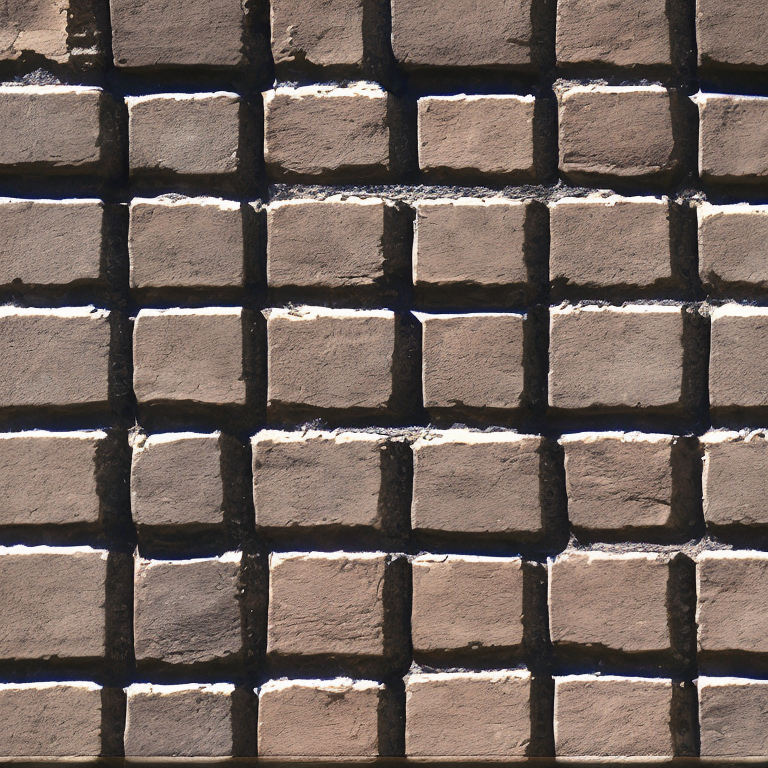

In [ ]:
precision_scope = autocast
prompt = "brick texture"
n_samples = 1
start_code = torch.randn([n_samples, 4, 768 // 8, 768 // 8], device=device)
with torch.no_grad(), \
    precision_scope("cuda"), \
    model.ema_scope():
        uc = None
        # if opt.scale != 1.0:
        #     uc = model.get_learned_conditioning(1 * [""])
        # if isinstance(prompt, tuple):
        #     prompts = list(prompts)
        uc = model.get_learned_conditioning(1 * [""])
        c = model.get_learned_conditioning([prompt])
        shape = [4, 768 // 8, 768 // 8]
        samples, _ = sampler.sample(S=50,
                                    conditioning=c,
                                    batch_size=1,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=7.0,
                                    unconditional_conditioning=uc,
                                    eta=0.0,
                                    x_T=start_code
        )

        x_samples = model.decode_first_stage(samples)
        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

        for x_sample in x_samples:
            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
            img = Image.fromarray(x_sample.astype(np.uint8))
img

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it]


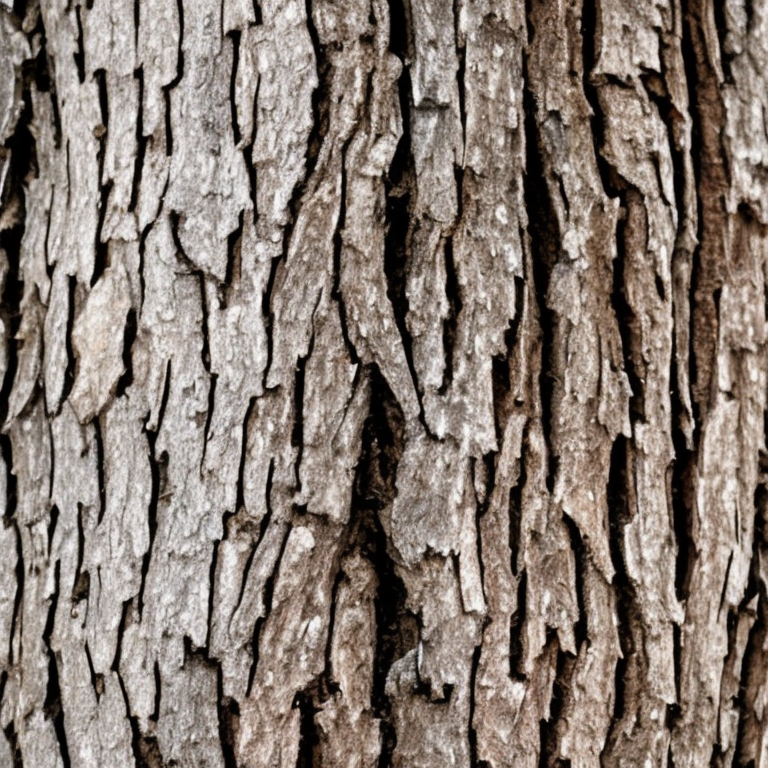

In [ ]:
precision_scope = autocast
prompt = "bark texture"
n_samples = 1
start_code = torch.randn([n_samples, 4, 768 // 8, 768 // 8], device=device)
with torch.no_grad(), \
    precision_scope("cuda"), \
    model.ema_scope():
        uc = None
        # if opt.scale != 1.0:
        #     uc = model.get_learned_conditioning(1 * [""])
        # if isinstance(prompt, tuple):
        #     prompts = list(prompts)
        uc = model.get_learned_conditioning(1 * [""])
        c = model.get_learned_conditioning([prompt])
        shape = [4, 768 // 8, 768 // 8]
        samples, _ = sampler.sample(S=50,
                                    conditioning=c,
                                    batch_size=1,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=7.0,
                                    unconditional_conditioning=uc,
                                    eta=0.0,
                                    x_T=start_code
        )

        x_samples = model.decode_first_stage(samples)
        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

        for x_sample in x_samples:
            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
            img = Image.fromarray(x_sample.astype(np.uint8))
img

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


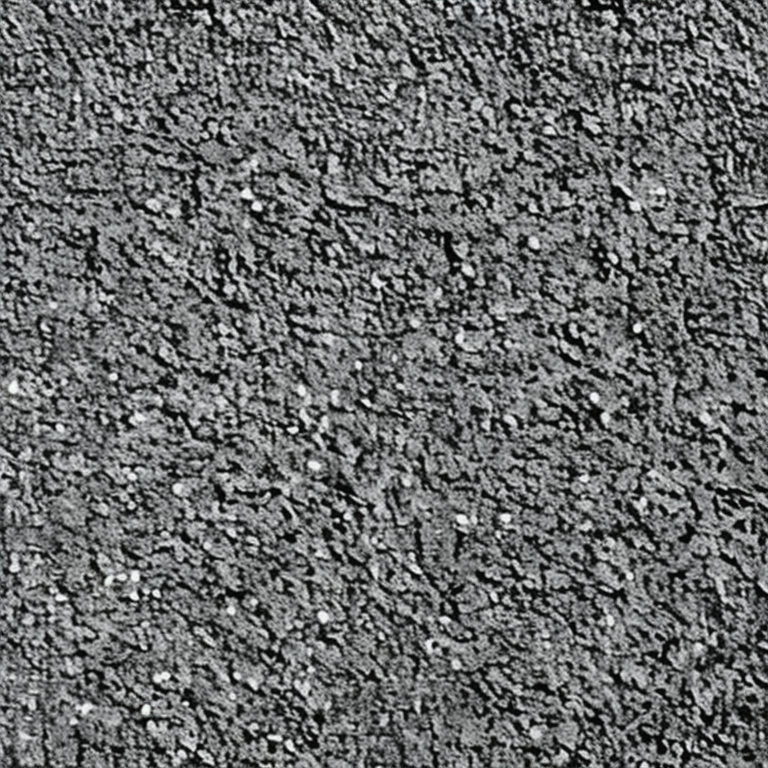

In [ ]:
precision_scope = autocast
prompt = "asphalt ground texture"
n_samples = 1
start_code = torch.randn([n_samples, 4, 768 // 8, 768 // 8], device=device)
with torch.no_grad(), \
    precision_scope("cuda"), \
    model.ema_scope():
        uc = None
        # if opt.scale != 1.0:
        #     uc = model.get_learned_conditioning(1 * [""])
        # if isinstance(prompt, tuple):
        #     prompts = list(prompts)
        uc = model.get_learned_conditioning(1 * [""])
        c = model.get_learned_conditioning([prompt])
        shape = [4, 768 // 8, 768 // 8]
        samples, _ = sampler.sample(S=50,
                                    conditioning=c,
                                    batch_size=1,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=7.0,
                                    unconditional_conditioning=uc,
                                    eta=0.0,
                                    x_T=start_code
        )

        x_samples = model.decode_first_stage(samples)
        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

        for x_sample in x_samples:
            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
            img = Image.fromarray(x_sample.astype(np.uint8))
img

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


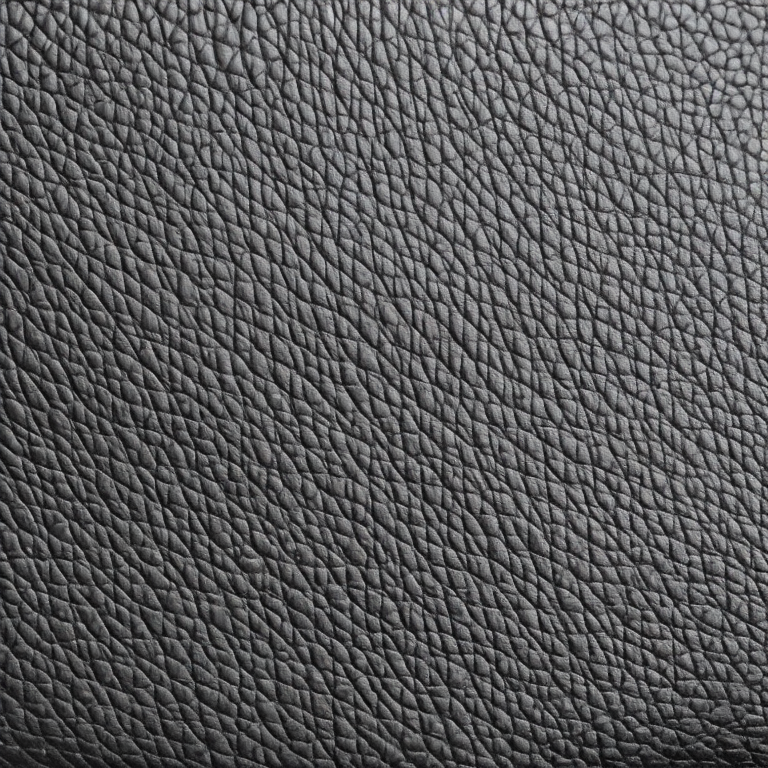

In [ ]:
precision_scope = autocast
prompt = "leather texture"
n_samples = 1
start_code = torch.randn([n_samples, 4, 768 // 8, 768 // 8], device=device)
with torch.no_grad(), \
    precision_scope("cuda"), \
    model.ema_scope():
        uc = None
        # if opt.scale != 1.0:
        #     uc = model.get_learned_conditioning(1 * [""])
        # if isinstance(prompt, tuple):
        #     prompts = list(prompts)
        uc = model.get_learned_conditioning(1 * [""])
        c = model.get_learned_conditioning([prompt])
        shape = [4, 768 // 8, 768 // 8]
        samples, _ = sampler.sample(S=50,
                                    conditioning=c,
                                    batch_size=1,
                                    shape=shape,
                                    verbose=False,
                                    unconditional_guidance_scale=7.0,
                                    unconditional_conditioning=uc,
                                    eta=0.0,
                                    x_T=start_code
        )

        x_samples = model.decode_first_stage(samples)
        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

        for x_sample in x_samples:
            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
            img = Image.fromarray(x_sample.astype(np.uint8))
img